In [ ]:
import numpy as np
import os, datetime
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, roc_auc_score, roc_curve,auc, classification_report
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
# Set GPU memory growth on

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

data_dir = "drive/MyDrive/AI_project/AI_dataset5"
data_dir = pathlib.Path(data_dir)

save_dir = "drive/MyDrive/AI_project/Models"
save_dir = pathlib.Path(save_dir)

logs_dir = "drive/MyDrive/AI_project/Logs"
logs_dir = pathlib.Path(data_dir)

In [ ]:
# Clear any logs from previous runs
#rm -rf logs_dir

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

### Create a dataset

In [ ]:
import os
file_names = os.listdir("/content/drive/My Drive/AI_project/AI_dataset5")
file_names


In [ ]:
batch_size = 32
img_width = 200
img_height = 200
classes = ['N', 'A', 'O', '~']

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_width,img_height),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_width,img_height),
  batch_size=batch_size)


In [ ]:
class_names_t = train_ds.class_names
print(class_names_t)

class_names_v = val_ds.class_names
print(class_names_v)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_v[labels[i]])
    plt.axis("off")
plt.show()

### Standardize the data


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# define layers
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer_1 = tf.keras.layers.Dense(512,activation='relu')
prediction_layer_2 = tf.keras.layers.Dense(256,activation='relu')
prediction_layer_3 = tf.keras.layers.Dense(128,activation='relu')
prediction_layer_4 = tf.keras.layers.Dense(4)

In [ ]:
def res_net_block(input_data, filters, conv_size):
  x = layers.Conv2D(filters, conv_size, activation='relu', padding='same',kernel_regularizer=regularizers.l2(1e-4))(input_data)
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Conv2D(filters, conv_size, activation=None, padding='same',kernel_regularizer=regularizers.l2(1e-4))(x)
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Add()([x, input_data]) # skip connection
  x = layers.Activation('relu')(x)
  return x

In [ ]:
custom_early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                                      patience = 6, 
                                      min_delta = 0.01, 
                                      mode='max')

In [ ]:
# the model
IMG_SIZE = (200,200)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

inputs = tf.keras.Input(shape=IMG_SHAPE)

x = normalization_layer(inputs)

x = tf.keras.layers.Conv2D(32,(3,3), activation='relu',padding="same",kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.SpatialDropout2D(0.2)(x)
x = layers.BatchNormalization()(x)

num_res_net_blocks = 5
for i in range(num_res_net_blocks):
    x = res_net_block(x, 32, 3)

x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(64,(5,5), activation='relu',padding="same",kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.SpatialDropout2D(0.2)(x)
x = layers.BatchNormalization()(x)

num_res_net_blocks = 5
for i in range(num_res_net_blocks):
    x = res_net_block(x, 64, 5)

x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = tf.keras.layers.Conv2D(128,(9,9), activation='relu',padding="same",kernel_regularizer=regularizers.l2(1e-4))(x)
x = tf.keras.layers.SpatialDropout2D(0.2)(x)
x = layers.BatchNormalization()(x)

num_res_net_blocks = 5
for i in range(num_res_net_blocks):
    x = res_net_block(x, 128, 9)

x = tf.keras.layers.MaxPooling2D((2,2))(x)

x = global_average_layer(x)

x = prediction_layer_1(x,training=True)
x = tf.keras.layers.Dropout(0.2)(x)

x = prediction_layer_2(x,training=True)
x = tf.keras.layers.Dropout(0.2)(x)

x = prediction_layer_3(x,training=True)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer_4(x, training=True)

model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001


model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(val_ds) 

In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    callbacks=[custom_early_stopping])

Epoch 1/50
404/404 [==============================] - 5246s 13s/step - loss: 1.5148 - accuracy: 0.3940 - val_loss: 2.2670 - val_accuracy: 0.2525
Epoch 2/50
404/404 [==============================] - 538s 1s/step - loss: 1.3350 - accuracy: 0.5031 - val_loss: 1.3298 - val_accuracy: 0.5068
Epoch 3/50
404/404 [==============================] - 538s 1s/step - loss: 1.2387 - accuracy: 0.5663 - val_loss: 1.1629 - val_accuracy: 0.6111
Epoch 4/50
404/404 [==============================] - 538s 1s/step - loss: 1.1448 - accuracy: 0.6166 - val_loss: 1.0465 - val_accuracy: 0.6624
Epoch 5/50
404/404 [==============================] - 538s 1s/step - loss: 1.0798 - accuracy: 0.6507 - val_loss: 0.9581 - val_accuracy: 0.6921
Epoch 6/50
404/404 [==============================] - 537s 1s/step - loss: 1.0322 - accuracy: 0.6709 - val_loss: 0.9233 - val_accuracy: 0.7095
Epoch 7/50
404/404 [==============================] - 537s 1s/step - loss: 0.9926 - accuracy: 0.6931 - val_loss: 0.9018 - val_accuracy: 0.73

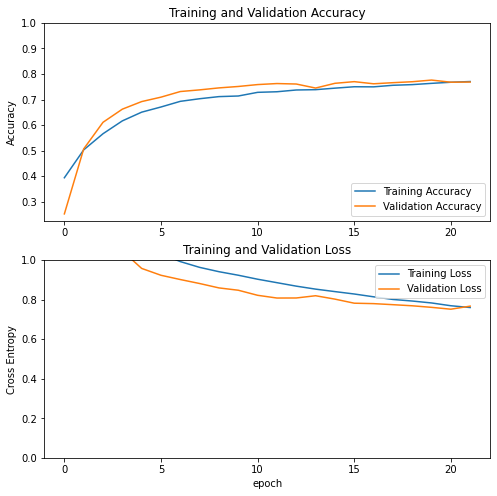

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# save the model
model_save_name = 'classifier_final_cnn_many_layers.pt'
path = os.path.join(save_dir,model_save_name)
model.save(path)

INFO:tensorflow:Assets written to: drive/MyDrive/AI_project/Models/classifier_final_cnn_many_layers.pt/assets


In [ ]:
# get validation dataset labels
val_labels = np.concatenate([y for x,y in val_ds],axis=0)
val_labels_count = Counter(val_labels)
val_labels_count


In [ ]:
# predict validation set labels
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = model.predict(val_ds)
pred_per = probability_model.predict(val_ds)
max = np.argmax(predictions,axis=1)



In [ ]:
print(val_labels.shape)
print(predictions)

(3232,)
[[-0.94501954 -2.1015708   1.9921561   3.089431  ]
 [-0.48281547 -3.6383634   3.306597    3.3808413 ]
 [-2.094463    3.0203426  -1.3959237  -0.5832436 ]
 ...
 [ 7.091437   -5.1028233  -3.036681    2.2541873 ]
 [ 2.6686318  -2.980048   -3.80962     4.299637  ]
 [ 8.787388   -6.14559    -3.7511823   2.4734209 ]]


In [ ]:
# training dataset labels
train_labels = np.concatenate([y for x,y in train_ds],axis=0)
train_labels_count = Counter(train_labels)
train_labels_count

In [ ]:
# confusion matrix for validation data
cf_a = tf.math.confusion_matrix(
    val_labels, max, num_classes=4, weights=None, dtype=tf.dtypes.int32,
    name=None
)

In [ ]:
# function for confusion matrix plotting

def plot_confusion_matrix(cm, class_names,title="Confusion Matrix"):
  """
  Returns a matplotlib figure containing the plotted confusion matrix.

  Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
  """
  
  figure,ax = plt.subplots(figsize=(8, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar(im,ax=ax)
  ax.set_aspect('auto')
  plt.title(title)
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  #cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure

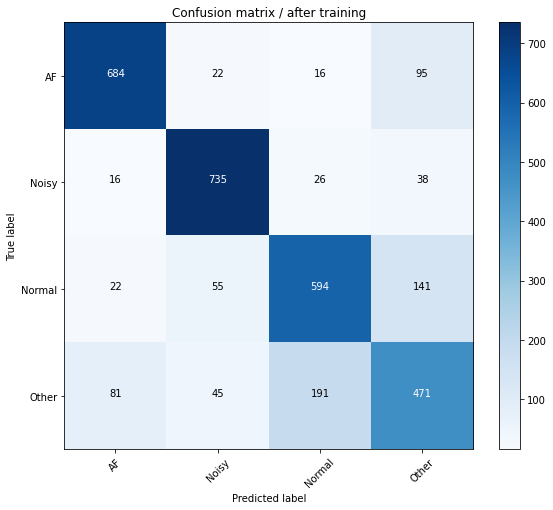

In [ ]:
# plot the matrix
cf_fig_a = plot_confusion_matrix(cf_a.numpy(),class_names_v, "Confusion matrix / after training")
cf_fig_a.show()

In [ ]:
def plot_multiclass_roc(X_test, y_test, label, n_classes, figsize=(17, 6)):
    y_score = probability_model.predict(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i],label[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()



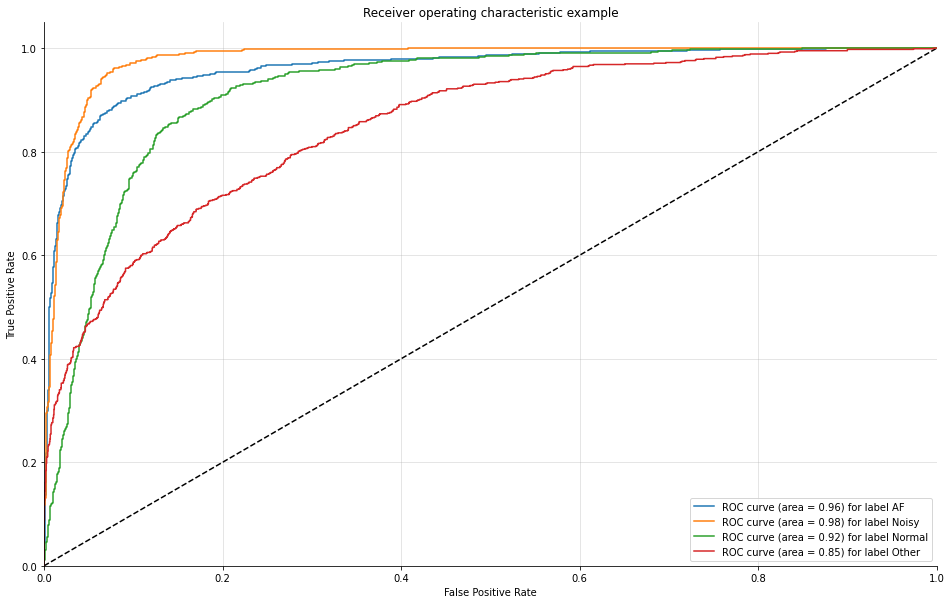

In [ ]:
# plot ROC curves
plot_multiclass_roc(val_ds, val_labels, class_names_v, n_classes=4, figsize=(16, 10))

In [ ]:
# classification reports
print(classification_report(val_labels, max, target_names=class_names_v))

              precision    recall  f1-score   support

          AF       0.85      0.84      0.84       817
       Noisy       0.86      0.90      0.88       815
      Normal       0.72      0.73      0.72       812
       Other       0.63      0.60      0.61       788

    accuracy                           0.77      3232
   macro avg       0.76      0.77      0.77      3232
weighted avg       0.77      0.77      0.77      3232



In [ ]:
# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 32)
conv2d_4 (3, 3, 32, 32)
conv2d_5 (3, 3, 32, 32)
conv2d_6 (3, 3, 32, 32)
conv2d_7 (3, 3, 32, 32)
conv2d_8 (3, 3, 32, 32)
conv2d_9 (3, 3, 32, 32)
conv2d_10 (3, 3, 32, 32)
conv2d_11 (5, 5, 32, 64)
conv2d_12 (5, 5, 64, 64)
conv2d_13 (5, 5, 64, 64)
conv2d_14 (5, 5, 64, 64)
conv2d_15 (5, 5, 64, 64)
conv2d_16 (5, 5, 64, 64)
conv2d_17 (5, 5, 64, 64)
conv2d_18 (5, 5, 64, 64)
conv2d_19 (5, 5, 64, 64)
conv2d_20 (5, 5, 64, 64)
conv2d_21 (5, 5, 64, 64)
conv2d_22 (9, 9, 64, 128)
conv2d_23 (9, 9, 128, 128)
conv2d_24 (9, 9, 128, 128)
conv2d_25 (9, 9, 128, 128)
conv2d_26 (9, 9, 128, 128)
conv2d_27 (9, 9, 128, 128)
conv2d_28 (9, 9, 128, 128)
conv2d_29 (9, 9, 128, 128)
conv2d_30 (9, 9, 128, 128)
conv2d_31 (9, 9, 128, 128)
conv2d_32 (9, 9, 128, 128)


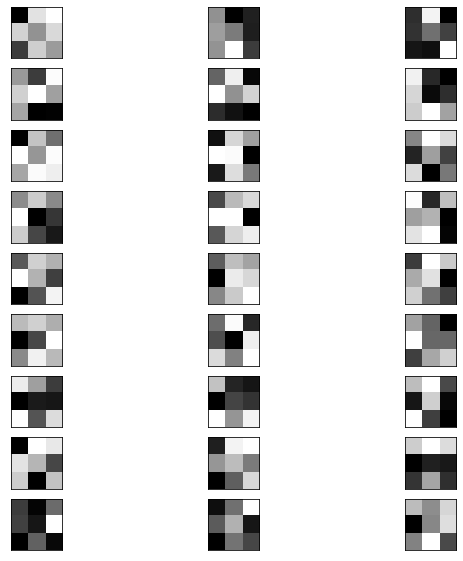

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[2].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 9, 1

# create a new figure
plt.figure(figsize=(10, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
4# retrieve weights from the second hidden layer
filters, biases = model.layers[6].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 9, 1

# create a new figure
plt.figure(figsize=(10, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

ValueError: ignored

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[10].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 9, 1

# create a new figure
plt.figure(figsize=(10, 10))

for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
model.layers
